In [ ]:
pip install impedance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.1 MB/s eta 0:00:00


In [ ]:

!pip install --quiet lmfit pandas matplotlib openpyxl seaborn


/usr/local/lib/python3.11/dist-packages/lmfit/minimizer.py:2325: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1720
    # data points      = 402
    # variables        = 10
    chi-square         = 76.7260728
    reduced chi-square = 0.19572978
    Akaike info crit   = -645.796623
    Bayesian info crit = -605.832102
##  Warning: uncertainties could not be estimated:
    Ls:      at boundary
    k:       at boundary
    Cw1:     at initial value
    Cw1:     at boundary
    Cw2:     at initial value
    Cw2:     at boundary
    Ccm:     at initial value
    Ccm:     at boundary
    Cstray:  at initial value
    Cstray:  at boundary
[[Variables]]
    Rw:      11.7878796 (init = 13.38514)
    Ls:      1.0000e-09 (init = 2.088899e-08)
    L:       6.8271e-06 (init = 4.589114e-06)
    k:       0.10000000 (init = 0.1016133)
    Cw1:     1.6349e-10 (init = 7.610683e-10)
    Cw2:     7.5272e-11 (init = 6.856366e-11)
    Rser:    39.7790658 (init = 2.099837)
    Rp:      9999.07374 (init = 4456.625)
    Ccm:     2.3955e-11 (in

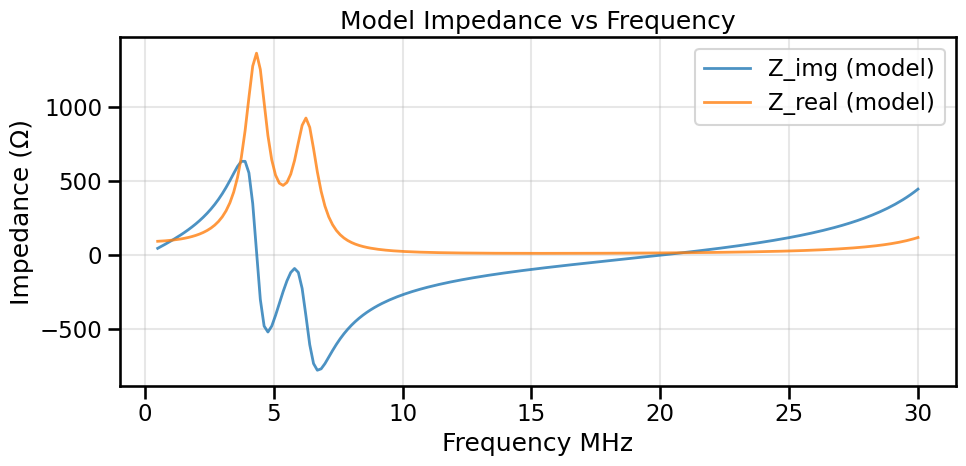

In [ ]:


import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from lmfit import Parameters, Minimizer, report_fit
j = 1j; sns.set_context('talk')

# data
df   = pd.read_excel('Impedence_Data.xlsx')
f_Hz = df['Freq Hz'].to_numpy()
w    = 2*np.pi*f_Hz
Zdat = df['Z_real'].to_numpy() + 1j*df['Z_imaginary'].to_numpy()

# Model
def Z_two_coils(w,Rw,Ls,L,k,Cw1,Cw2,Rser,Rp,Ccm,Cstray):
    M  = k*L
    Zlead = Rw + j*w*Ls
    Zs1   = Rser + j*w*L
    Zs2   = Zs1
    Yp1   = 1/Rp + j*w*Cw1
    Yp2   = 1/Rp + j*w*Cw2
    Z1    = 1/(1/Zs1 + Yp1)
    Z2    = 1/(1/Zs2 + Yp2)
    Zmut  = j*w*2*M             # mutual term
    Zser  = Zlead + Z1 + Z2 + Zmut
    Zcm   = 1/(1/Zser + j*w*Ccm)
    return 1/(1/Zcm + j*w*Cstray)

def resid(p,w,Zt):
    v=p.valuesdict(); Zm=Z_two_coils(w,**v)
    scl=1e-12+np.abs(Zt)
    return np.r_[ (Zm.real-Zt.real)/scl, (Zm.imag-Zt.imag)/scl ]

# parameters & bounds
p=Parameters()
p.add('Rw', value=1,  min=0.01,max=20)
p.add('Ls', value=3e-7,min=1e-9,max=5e-6)

p.add('L',  value=2e-6,min=5e-7,max=7e-6)
p.add('k',  value=0.8, min=0.1,max=0.99)

p.add('Cw1',value=9e-10,min=1e-11,max=8e-8)   # allow decade spread
p.add('Cw2',value=5e-10,min=1e-11,max=8e-8)   # **independent now**

p.add('Rser',value=2,  min=0.1,max=200)
p.add('Rp',  value=800,min=10, max=1e4)

p.add('Ccm', value=2e-11,min=5e-12,max=2e-10)
p.add('Cstray',value=3e-13,min=1e-13,max=5e-12)

#  global + local fit
mini=Minimizer(resid,p,fcn_args=(w,Zdat))
g=mini.minimize(method='differential_evolution',
                popsize=15,maxiter=400,workers=1,
                polish=False,updating='deferred',tol=1e-6)
best=mini.minimize(method='leastsq',params=g.params)
report_fit(best, min_correl=0.3)

#  build fitted curve & save for plotting
vals=best.params.valuesdict()
Zfit=Z_two_coils(w,**vals)

#real/imag vs frequency plot
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(f_Hz/1e6, Zfit.imag,'-',lw=2,alpha=0.8,label='Z_img (model)',color='#1f77b4')
ax.plot(f_Hz/1e6, Zfit.real,'-',lw=2,alpha=0.8,label='Z_real (model)',color='#ff7f0e')
ax.set_xscale('linear'); ax.set_xlabel('Frequency MHz')
ax.set_ylabel('Impedance (Ω)')
ax.set_title('Model Impedance vs Frequency')
ax.grid(alpha=.3); ax.legend()
plt.tight_layout(); plt.show()




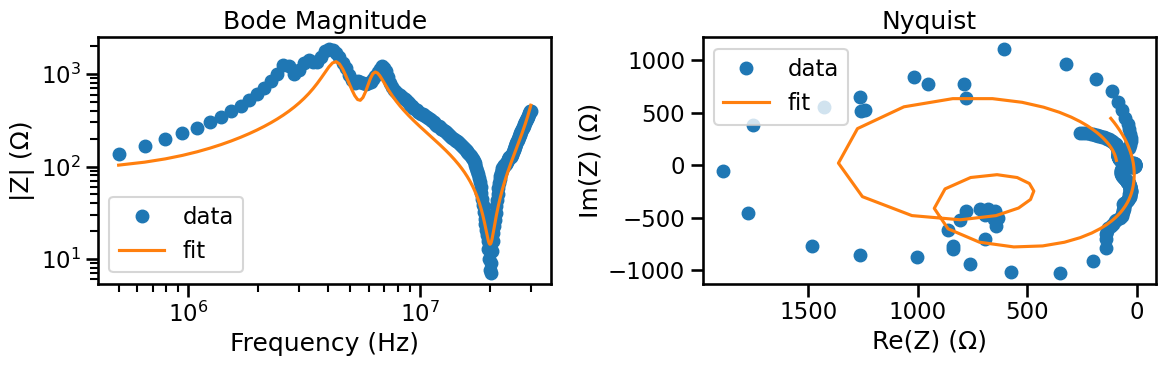

In [ ]:

vals=best.params.valuesdict()
Zfit=Z_two_coils(w,**vals)

fig,(ax1,axN)=plt.subplots(1,2,figsize=(12,4))
ax1.loglog(f_Hz,np.abs(Zdat),'o',label='data')
ax1.loglog(f_Hz,np.abs(Zfit),'-',label='fit')
ax1.set_xlabel('Frequency (Hz)');ax1.set_ylabel('|Z| (Ω)')
ax1.set_title('Bode Magnitude');ax1.legend()

axN.plot(Zdat.real,Zdat.imag,'o',label='data')
axN.plot(Zfit.real,Zfit.imag,'-',label='fit')
axN.set_xlabel('Re(Z) (Ω)');axN.set_ylabel('Im(Z) (Ω)')
axN.set_title('Nyquist');axN.invert_xaxis();axN.legend()
plt.tight_layout();plt.show()


/usr/local/lib/python3.11/dist-packages/lmfit/minimizer.py:2325: RuntimeWarning: ignoring `maxiter` argument to `minimize()`. Use `max_nfev` instead.
  warnings.warn(maxeval_warning.format(maxnfev_alias, thisfuncname()),


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 848
    # data points      = 402
    # variables        = 9
    chi-square         = 85.8032770
    reduced chi-square = 0.21832895
    Akaike info crit   = -602.846746
    Bayesian info crit = -566.878677
[[Variables]]
    Rw:     10.00000000 +/- 2.72046556 (27.20%) (init = 9.998431)
    Ls:      1.0000e-09 +/- 0.01686752 (1686751466.34%) (init = 1.240089e-09)
    L:       6.0000e-06 +/- 0.00301537 (50256.11%) (init = 5.998272e-06)
    k:       0.10000000 +/- 0.02264010 (22.64%) (init = 0.1000002)
    Cw1:     1.1586e-10 +/- 7.4263e-12 (6.41%) (init = 1.157212e-10)
    Cw2:     1.1586e-10 +/- 7.4263e-12 (6.41%) == 'Cw1'
    Rser:    58.1739948 +/- 12.3186804 (21.18%) (init = 57.56995)
    Rp:      3814.26999 +/- 5797.08974 (151.98%) (init = 2979.929)
    Ccm:     2.9654e-11 +/- 2.4943e-07 (841136.36%) (init = 3.060858e-11)
    Cstray:  5.4817e-13 +/- 2.4943e-07 (45502360.19%) (init = 1.325779e-12)
[[Correlati

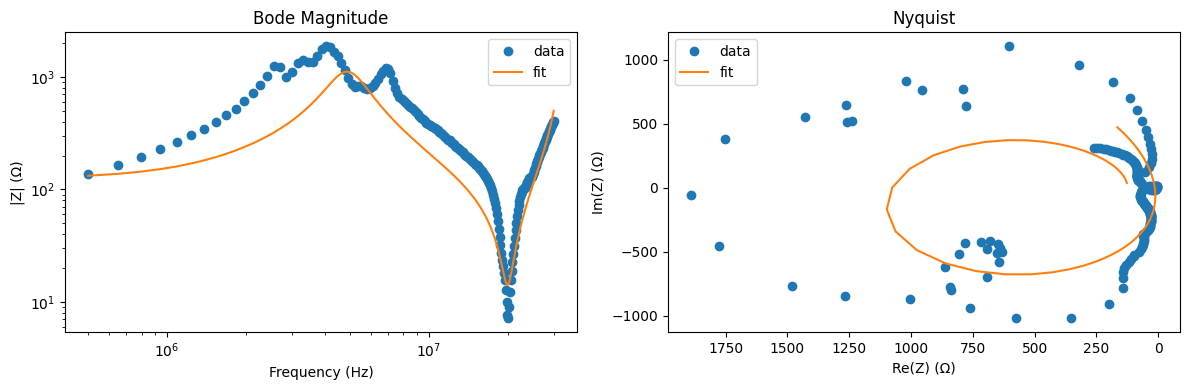

In [ ]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from lmfit import Parameters, Minimizer, report_fit
j=1j

# ╔══  load data  ══════════════════════════════════════════════════════╗
df   = pd.read_excel("Impedence_Data.xlsx")
f_Hz = df["Freq Hz"].to_numpy()
w    = 2*np.pi*f_Hz

Zdat = df["Z_real"].to_numpy() + 1j*df["Z_imaginary"].to_numpy()

# ╔══  IMPEDANCE FUNCTION with Ccm  ════════════════════════════════════╗
def Z_two_coils(w,Rw,Ls,L,k,Cw1,Cw2,Rser,Rp,Ccm,Cstray):
    M     = k*L
    Zlead = Rw + j*w*Ls

    # full tank for each coil
    Zser1 = Rser + j*w*L
    Zser2 = Zser1
    Yp1   = 1/Rp + j*w*Cw1
    Yp2   = 1/Rp + j*w*Cw2
    Z1    = 1/(1/Zser1 + Yp1)
    Z2    = 1/(1/Zser2 + Yp2)

    # mutual coupling term for coils in series
    Zmut  = j*w*2*M

    Zseries = Zlead + Z1 + Z2 + Zmut     # up to port

    # NEW: common-mode shunt to ground before coils
    Ycm   = j*w*Ccm
    Zcm   = 1/(1/Zseries + Ycm)

    # OLD tiny shunt at port
    Ztot  = 1/(1/Zcm + j*w*Cstray)
    return Ztot

# ╔══  residual (relative error)  ══════════════════════════════════════╗
def resid(pars,w,Zt):
    v=pars.valuesdict()
    Zm=Z_two_coils(w,**v)
    s=1e-12+np.abs(Zt)
    return np.hstack([(Zm.real-Zt.real)/s,(Zm.imag-Zt.imag)/s])

# ╔══  parameter set & generous bounds  ════════════════════════════════╗
p=Parameters()
p.add('Rw',   value=1,   min=0.01,  max=10)
p.add('Ls',   value=3e-7,min=1e-9,  max=3e-6)

p.add('L',    value=1.8e-6,min=5e-7,max=6e-6)
p.add('k',    value=0.8,  min=0.1,  max=0.99)

p.add('Cw1',  value=8e-10,min=1e-11,max=5e-8)
p.add('Cw2',  expr='Cw1')                    # keep symmetry first

p.add('Rser', value=2,   min=0.1,  max=200)
p.add('Rp',   value=800, min=10,   max=5e3)

p.add('Ccm',  value=1e-11,min=5e-12,max=1e-10)   # **NEW** 5–100 pF
p.add('Cstray',value=3e-13,min=1e-13,max=3e-12)

# ╔══  global + local fit  ════════════════════════════════════════════╗
mini=Minimizer(resid,p,fcn_args=(w,Zdat))
global_fit=mini.minimize(method='differential_evolution',
                         maxiter=400,popsize=15,updating='deferred',
                         polish=False,workers=1,tol=1e-6)
best=mini.minimize(method='leastsq',params=global_fit.params)
report_fit(best)

# ╔══  plot  ══════════════════════════════════════════════════════════╗
vals=best.params.valuesdict()
Zfit=Z_two_coils(w,**vals)

fig,(ax1,axN)=plt.subplots(1,2,figsize=(12,4))
ax1.loglog(f_Hz,np.abs(Zdat),'o',label='data')
ax1.loglog(f_Hz,np.abs(Zfit),'-',label='fit')
ax1.set_xlabel('Frequency (Hz)');ax1.set_ylabel('|Z| (Ω)')
ax1.set_title('Bode Magnitude');ax1.legend()

axN.plot(Zdat.real,Zdat.imag,'o',label='data')
axN.plot(Zfit.real,Zfit.imag,'-',label='fit')
axN.set_xlabel('Re(Z) (Ω)');axN.set_ylabel('Im(Z) (Ω)')
axN.set_title('Nyquist');axN.invert_xaxis();axN.legend()
plt.tight_layout();plt.show()
